# Classificação Multilabel de Doenças e Pragas nas Folhas de Café

# Importando Bibliotecas

In [1]:
#Import suppporting libraries
import tarfile
import urllib.request as urllib2
import os
import cv2multilabel_folhasDeCafé.ipynb
from os import listdir
from os.path import isfile, join
import re
#Import deep learning libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tqdm as tqdm
import tensorflow_hub as hub

#Import data analytics libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
#Import image visualization libraries
from PIL import *
from PIL import ImageFile
from PIL import Image
#System settings
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['WANDB_CONSOLE'] = 'off'
#Coloring for print outputs
class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [2]:
!nvidia-smi

Thu May 23 14:55:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Carregando Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Original

In [ ]:
!cp -r  /content/drive/MyDrive/TCC/Datasets/dataset_original/ /content/

In [ ]:
path='/content/dataset_original'


Augumented

In [ ]:
!cp -r /content/drive/MyDrive/TCC/Datasets/DatasetMerged-com-augumentation-20231024T141319Z-001.zip /content/

In [ ]:
!unzip /content/DatasetMerged-com-augumentation-20231024T141319Z-001.zip

In [ ]:
path='/content/DatasetMerged-com-augumentation'

Balanceado


In [4]:
!cp -r /content/drive/MyDrive/TCC/Datasets/dataset_original_aumentado_balanceado.rar /content/

In [5]:
!pip install patool
import patoolib

patoolib.extract_archive('/content/dataset_original_aumentado_balanceado.rar', outdir='/content/')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.6 MB/s eta 0:00:00


INFO patool: Extracting /content/dataset_original_aumentado_balanceado.rar ...
INFO:patool:Extracting /content/dataset_original_aumentado_balanceado.rar ...
INFO patool: running /usr/bin/unrar x -- /content/dataset_original_aumentado_balanceado.rar
INFO:patool:running /usr/bin/unrar x -- /content/dataset_original_aumentado_balanceado.rar
INFO patool:     with cwd='/content/', input=''
INFO:patool:    with cwd='/content/', input=''
INFO patool: ... /content/dataset_original_aumentado_balanceado.rar extracted to `/content/'.
INFO:patool:... /content/dataset_original_aumentado_balanceado.rar extracted to `/content/'.


'/content/'

In [6]:
path='/content/dataset_original_aumentado'

BRACOL

In [4]:
!cp -r '/content/drive/MyDrive/TCC/Datasets/Dataset_Bracol_A.rar' /content/

In [5]:
!pip install patool
import patoolib

patoolib.extract_archive('/content/Dataset_Bracol_A.rar', outdir='/content/')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.2 MB/s eta 0:00:00


INFO patool: Extracting /content/Dataset_Bracol_A.rar ...
INFO:patool:Extracting /content/Dataset_Bracol_A.rar ...
INFO patool: running /usr/bin/unrar x -- /content/Dataset_Bracol_A.rar
INFO:patool:running /usr/bin/unrar x -- /content/Dataset_Bracol_A.rar
INFO patool:     with cwd='/content/', input=''
INFO:patool:    with cwd='/content/', input=''
INFO patool: ... /content/Dataset_Bracol_A.rar extracted to `/content/'.
INFO:patool:... /content/Dataset_Bracol_A.rar extracted to `/content/'.


'/content/'

In [6]:
path='/content/symptom'

Variaveis

In [7]:
def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)

In [8]:
criar_diretorio("/content/dataset")

In [9]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3

>    Funções para divisão dos dados

In [10]:
#JMUBEN

cerscospora = path + '/Cerscospora'
healthy = path + '/Healthy'
leaf_rust = path + '/Leaf rust'
miner = path + '/Miner'
phoma = path + '/Phoma'
folders = [healthy, leaf_rust, miner, cerscospora, phoma]
folders

['/content/dataset_original_aumentado/Healthy',
 '/content/dataset_original_aumentado/Leaf rust',
 '/content/dataset_original_aumentado/Miner',
 '/content/dataset_original_aumentado/Cerscospora',
 '/content/dataset_original_aumentado/Phoma']

In [10]:
# BRACOL

cerscospora = path + '/cercospora'
healthy = path + '/health'
leaf_rust = path + '/rust'
miner = path + '/miner'
phoma = path + '/phoma'
folders = [healthy, leaf_rust, miner, cerscospora, phoma]
folders

['/content/symptom/health',
 '/content/symptom/rust',
 '/content/symptom/miner',
 '/content/symptom/cercospora',
 '/content/symptom/phoma']

In [ ]:
cerscospora = path + '/Cerscospora'
# healthy = path + '/Healthy'
leaf_rust = path + '/Leaf rust'
miner = path + '/Miner'
phoma = path + '/Phoma'
folders = [leaf_rust, miner, cerscospora, phoma]
folders

['/content/dataset_original/Healthy',
 '/content/dataset_original/Rust',
 '/content/dataset_original/Miner',
 '/content/dataset_original/Cercospora',
 '/content/dataset_original/Phoma']

In [ ]:
# def create_mydataset():
#   X_train, y_train = [], []
#   for idx, foldername in enumerate(folders):
#     for filename in os.listdir(foldername):
#       out = '/content/dataset/{}.png'.format(filename.split('.')[0])
#       image = cv2.imread(foldername+'/'+filename)
#       cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
#       img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
#       img = tf.keras.utils.img_to_array(img)
#       img= img/255.
#       X_train.append(img)
#       vec = np.zeros(4)
#       vec[idx] = 1
#       y_train.append(vec)
#   X = np.array(X_train)
#   y = np.array(y_train)
#   return X, y

# grayscale

Para 4 classes

In [ ]:

def create_mydataset():
    X_train, y_train = [], []
    for filename in os.listdir(leaf_rust):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(leaf_rust+'/'+filename)
      cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
      img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
      img = tf.keras.utils.img_to_array(img)
      img= img/255.
      X_train.append(img)
      y_train.append([1, 0, 0, 0])
    for filename in os.listdir(miner):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(miner+'/'+filename)
      cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
      img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
      img = tf.keras.utils.img_to_array(img)
      img= img/255.
      X_train.append(img)
      y_train.append([0, 1, 0, 0])
    for filename in os.listdir(cerscospora):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(cerscospora+'/'+filename)
      cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
      img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
      img = tf.keras.utils.img_to_array(img)
      img= img/255.
      X_train.append(img)
      y_train.append([0, 0, 1, 0])
    for filename in os.listdir(phoma):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(phoma+'/'+filename)
      cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
      img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
      img = tf.keras.utils.img_to_array(img)
      img= img/255.
      X_train.append(img)
      y_train.append([0, 0, 0, 1])
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y


Para 5 classes

In [ ]:

def create_mydataset():
    X_train, y_train = [], []
    for filename in os.listdir(healthy):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(healthy+'/'+filename)
      cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
      img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
      img = tf.keras.utils.img_to_array(img)
      img= img/255.
      X_train.append(img)
      y_train.append([1, 0, 0, 0, 0])
    for filename in os.listdir(leaf_rust):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(leaf_rust+'/'+filename)
      cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
      img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
      img = tf.keras.utils.img_to_array(img)
      img= img/255.
      X_train.append(img)
      y_train.append([0, 1, 0, 0, 0])
    for filename in os.listdir(miner):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(miner+'/'+filename)
      cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
      img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
      img = tf.keras.utils.img_to_array(img)
      img= img/255.
      X_train.append(img)
      y_train.append([0, 0, 1, 0, 0])
    for filename in os.listdir(cerscospora):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(cerscospora+'/'+filename)
      cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
      img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
      img = tf.keras.utils.img_to_array(img)
      img= img/255.
      X_train.append(img)
      y_train.append([0, 0, 0, 1, 0])
    for filename in os.listdir(phoma):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(phoma+'/'+filename)
      cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
      img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
      img = tf.keras.utils.img_to_array(img)
      img= img/255.
      X_train.append(img)
      y_train.append([0, 0, 0, 0, 1])
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y


# RGB

In [11]:
#  RGB
def create_mydataset():
    X_train, y_train = [], []

    for filename in os.listdir(healthy):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(healthy+'/'+filename)

      if image is not None:
        cv2.imwrite(out, image)  # Salvar a imagem original
        img = tf.keras.utils.load_img(out, target_size=(224, 224), color_mode="rgb")
        img = tf.keras.utils.img_to_array(img)
        img = img/255.
        X_train.append(img)
        y_train.append([1, 0, 0, 0, 0])
      else:
        print("Erro ao carregar a imagem:", filename)

    for filename in os.listdir(leaf_rust):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(leaf_rust+'/'+filename)
      if image is not None:
        cv2.imwrite(out, image)  # Salvar a imagem original
        img = tf.keras.utils.load_img(out, target_size=(224, 224), color_mode="rgb")
        img = tf.keras.utils.img_to_array(img)
        img = img/255.
        X_train.append(img)
        y_train.append([0, 1, 0, 0, 0])
      else:
        print("Erro ao carregar a imagem:", filename)

    for filename in os.listdir(miner):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(miner+'/'+filename)
      if image is not None:
        cv2.imwrite(out, image)  # Salvar a imagem original
        img = tf.keras.utils.load_img(out, target_size=(224, 224), color_mode="rgb")
        img = tf.keras.utils.img_to_array(img)
        img = img/255.
        X_train.append(img)
        y_train.append([0, 0, 1, 0, 0])
      else:
        print("Erro ao carregar a imagem:", filename)

    for filename in os.listdir(cerscospora):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(cerscospora+'/'+filename)
      if image is not None:
        cv2.imwrite(out, image)  # Salvar a imagem original
        img = tf.keras.utils.load_img(out, target_size=(224, 224), color_mode="rgb")
        img = tf.keras.utils.img_to_array(img)
        img = img/255.
        X_train.append(img)
        y_train.append([0, 0, 0, 1, 0])
      else:
        print("Erro ao carregar a imagem:", filename)

    for filename in os.listdir(phoma):
      out = '/content/dataset/{}.png'.format(filename.split('.')[0])
      image = cv2.imread(phoma+'/'+filename)
      if image is not None:
        cv2.imwrite(out, image)  # Salvar a imagem original
        img = tf.keras.utils.load_img(out, target_size=(224, 224), color_mode="rgb")
        img = tf.keras.utils.img_to_array(img)
        img = img/255.
        X_train.append(img)
        y_train.append([0, 0, 0, 0, 1])
      else:
        print("Erro ao carregar a imagem:", filename)

    X = np.array(X_train)
    y = np.array(y_train)
    return X, y


## **Divisão em Conjuntos de Dados para Treinamento dos Modelos**

Plot da quantidade de imagens

Total de Imagens = 5000


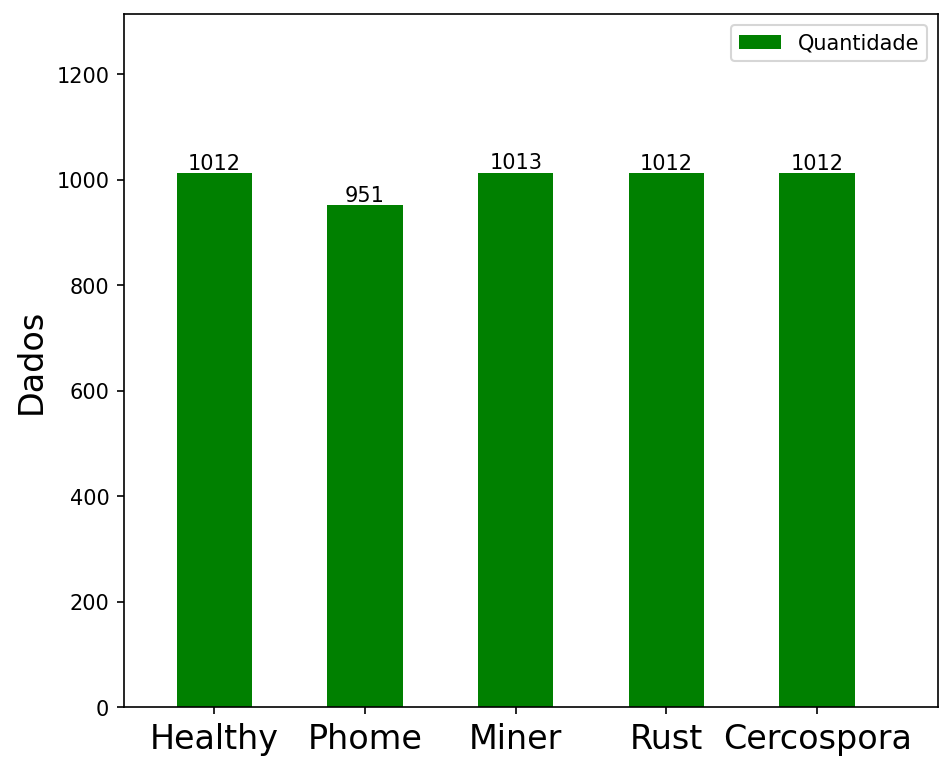

In [12]:
#JMUBEN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data_folder = '/content/dataset_original_aumentado'
healthy2 = len(os.listdir(data_folder +'/Healthy'))
phome2 = len(os.listdir(data_folder +'/Phoma'))
miner2 = len(os.listdir(data_folder +'/Miner'))
rust2 =  len(os.listdir(data_folder +'/Leaf rust'))
cercospora2 = len(os.listdir(data_folder +'/Cerscospora'))
total = healthy2 + phome2 + miner2 + rust2 + cercospora2

labels = [healthy2, phome2, miner2 ,rust2 ,cercospora2]

index = ['Healthy', 'Phome', 'Miner', 'Rust', 'Cercospora']

print('Total de Imagens =', total)

df = pd.DataFrame({'Quantidade': labels}, index=index)

fig, ax = plt.subplots(figsize=(7, 6) , dpi = 150)  # Ajuste os valores de largura e altura conforme necessário
ax = df.plot.bar(rot=0, color={'Quantidade': "green"}, ax=ax)

# Define manualmente os limites do eixo x
ax.set_xlim(-0.6, len(index) - 0.2)
plt.xticks(range(len(index)), index, fontsize=16)

ax.set_ylim(0, max(labels) + 300)

for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("Dados", fontsize=16)
plt.show()

Total de Imagens = 2491


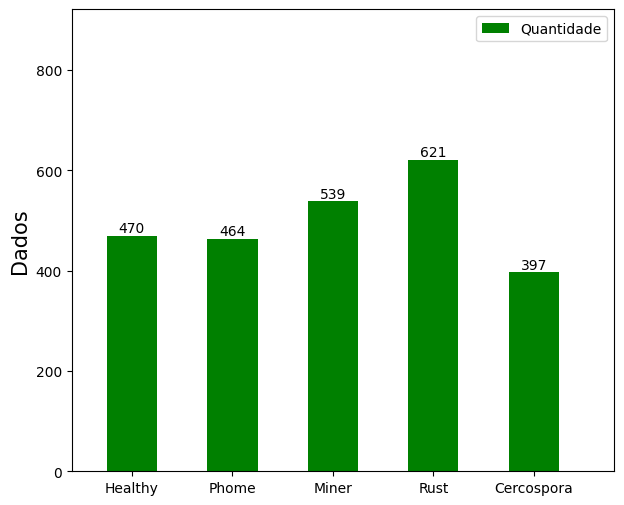

In [13]:
#BRACOL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data_folder = '/content/symptom'
healthy2 = len(os.listdir(data_folder +'/health'))
phome2 = len(os.listdir(data_folder +'/phoma'))
miner2 = len(os.listdir(data_folder +'/miner'))
rust2 =  len(os.listdir(data_folder +'/rust'))
cercospora2 = len(os.listdir(data_folder +'/cercospora'))
total = healthy2 + phome2 + miner2 + rust2 + cercospora2

labels = [healthy2, phome2, miner2 ,rust2 ,cercospora2]

index = ['Healthy', 'Phome', 'Miner', 'Rust', 'Cercospora']

print('Total de Imagens =', total)

df = pd.DataFrame({'Quantidade': labels}, index=index)
fig, ax = plt.subplots(figsize=(7, 6))  # Ajuste os valores de largura e altura conforme necessário
ax = df.plot.bar(rot=0, color={'Quantidade': "green"}, ax=ax)

# Define manualmente os limites do eixo x
ax.set_xlim(-0.6, len(index) - 0.2)
plt.xticks(range(len(index)), index)

ax.set_ylim(0, max(labels) + 300)

for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("Dados", fontsize=15)
plt.show()

In [13]:
#X, y = create_dataset_aug()
X, y = create_mydataset()
#((1225, 224, 224, 3), (1225, 5))
#num_folds=5
# Define the K-fold Cross Validator
#kfold = KFold(n_splits=num_folds, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, shuffle=True) # random_state=20,
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=20, shuffle=True) # random_state=20,
del X
del y


In [14]:
X_train.shape, X_val.shape, X_test.shape

((3500, 224, 224, 3), (750, 224, 224, 3), (750, 224, 224, 3))

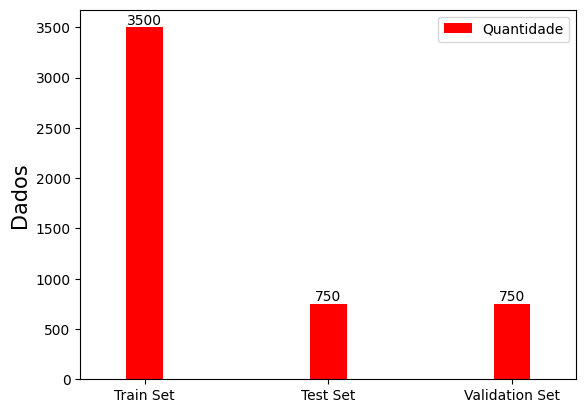

In [15]:
# divisão de dados
labels = [X_train.shape[0], X_test.shape[0], X_val.shape[0]]

index = ['Train Set', 'Test Set', 'Validation Set']

df = pd.DataFrame({'Quantidade': labels}, index=index)
ax = df.plot.bar(rot=0, color={'Quantidade': "red"}, width = 0.2)
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel("Dados", fontsize=15)
plt.show()

#                                                   **Definição Dos Modelos**

**PavicNet-MC**

In [ ]:
def residual_block(inputs):
  residual = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(inputs)
  residual = tf.keras.layers.BatchNormalization()(residual)
  residual = tf.keras.layers.ReLU()(residual)
  residual = tf.keras.layers.MaxPool2D(2)(residual)

  residual = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1)(residual)
  residual = tf.keras.layers.BatchNormalization()(residual)
  residual = tf.keras.layers.ReLU()(residual)
  residual = tf.keras.layers.MaxPool2D(2)(residual)

  residual = tf.keras.layers.Flatten()(residual) # ------------------------------------------------------------ COMENTA AQUI

  residual = tf.keras.layers.Dense(128, activation='relu')(residual)

  return residual
def Model_3():
  inputs = tf.keras.layers.Input(shape=(224, 224, 3))
  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D(4)(x)

  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  residual = residual_block(x)
  #residual = residual_block(residual)

  #x = tf.keras.layers.Flatten()(residual)
  x = tf.keras.layers.Dense(64, activation='relu')(residual)

  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(32, activation='relu')(x)

  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(16, activation='relu')(x)

  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(8, activation='relu')(x)

  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(5, activation='softmax')(x)

  #x = tf.keras.layers.add([x, residual]) #------------- bloco residual nas camadas densas
  model = tf.keras.Model(inputs=inputs, outputs=x)
  PavicNet_MC = model
  return PavicNet_MC



### -------------------------------

# Compilando o modelo PAVICNET-MC
model_all_0 = Model_3()

In [18]:
# v7

def residual_block(inputs):
  residual = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(inputs)
  residual = tf.keras.layers.BatchNormalization()(residual)
  residual = tf.keras.layers.ReLU()(residual)
  residual = tf.keras.layers.MaxPool2D(2)(residual)

  residual = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1)(residual)
  residual = tf.keras.layers.BatchNormalization()(residual)
  residual = tf.keras.layers.ReLU()(residual)
  residual = tf.keras.layers.MaxPool2D(2)(residual)

  residual = tf.keras.layers.Flatten()(residual) # ------------------------------------------------------------ COMENTA AQUI

  residual = tf.keras.layers.Dense(128, activation='relu')(residual)

  return residual
def Model_3():
  inputs = tf.keras.layers.Input(shape=(224, 224, 3))
  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D(4)(x)

  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  residual = residual_block(x)
  #residual = residual_block(residual)

  #x = tf.keras.layers.Flatten()(residual)
  x = tf.keras.layers.Dense(64, activation='relu')(residual)

  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(32, activation='relu')(x)

  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(16, activation='relu')(x)

  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(8, activation='relu')(x)

  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Dense(5, activation='softmax')(x)

  #x = tf.keras.layers.add([x, residual]) #------------- bloco residual nas camadas densas
  model = tf.keras.Model(inputs=inputs, outputs=x)
  PavicNet_MC = model
  return PavicNet_MC



### -------------------------------

# Compilando o modelo PAVICNET-MC
model_all_0 = Model_3()

**ResNet50**


In [17]:
# Compilando o modelo RESNET50
Resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

model_all_0 = Resnet

**InceptionResNet v2**

In [20]:
InceptionRe2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights=None, #"imagenet"
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

model_all_0 = InceptionRe2

**MobileNet V2**

In [ ]:
MobileNetv2 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=True,
    weights=None, #"imagenet",
    input_tensor=None,
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

model_all_0 = MobileNetv2

**DenseNet169**

In [ ]:
DenseNet169 = tf.keras.applications.densenet.DenseNet169(
    input_shape=(224, 224, 3),
    include_top=True,
    weights=None, #"imagenet",
    input_tensor=None,
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

model_all_0 = DenseNet169



# SHUFFLENET


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add,AveragePooling2D,Dense, AvgPool2D,BatchNormalization, ReLU, DepthwiseConv2D, Reshape, Permute,Conv2D, MaxPool2D, GlobalAveragePooling2D, concatenate

In [32]:
def channel_shuffle(x, groups):
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups

    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [33]:
def shuffle_unit(x, groups, channels,strides):

    y = x
    x = Conv2D(channels//4, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)

    x = DepthwiseConv2D(kernel_size = (3,3), strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)

    if strides == (2,2):
        channels = channels - y.shape[-1]
    x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)

    if strides ==(1,1):
        x =Add()([x,y])
    if strides == (2,2):
        y = AvgPool2D((3,3), strides = (2,2), padding = 'same')(y)
        x = concatenate([x,y])

    x = ReLU()(x)


    return x

In [34]:
def Shuffle_Net(nclasses, start_channels ,input_shape = (224,224,3)):

    groups = 2
    input = Input (input_shape)

    x =  Conv2D (24,kernel_size=3,strides = (2,2), padding = 'same', use_bias = True)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)

    x = MaxPool2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    for i,repetition in enumerate(repetitions):
        channels = start_channels * (2**i)

        x  = shuffle_unit(x, groups, channels,strides = (2,2))

        for i in range(repetition):
            x = shuffle_unit(x, groups, channels,strides=(1,1))

    x = GlobalAveragePooling2D()(x)

    output = Dense(n_classes,activation='softmax')(x)

    model = Model(input, output)
    return model

In [35]:
n_classes = 5
input_shape = (224,224,3)
start_channels = 600

model_all_0 = Shuffle_Net(n_classes, start_channels,input_shape)

**INFO**
weights='imagenet', são pré-treinados em um grande conjunto de dados chamado ImageNet. O ImageNet é um conjunto de dados contendo milhões de imagens classificadas em milhares de categorias diferentes, e é usado para tarefas de classificação de imagens. O treinamento prévio em ImageNet permite que o modelo tenha um conhecimento inicial sobre uma ampla variedade de objetos e padrões visuais.
Alguas classes q ele pode classificar são: gatos, cachorros, carros, barcos, aviões, algumas frutas como maçãs, bananas, laranjas, e entre outros objetos da flora, animais instrumentos e etc.

# **Treinamento dos Modelos**


In [36]:
# Resumo do modelo selecionado
model_all_0.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 112, 112, 24)         672       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 112, 112, 24)         96        ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 re_lu_8 (ReLU)              (None, 112, 112, 24)         0         ['batch_normalization_8[

In [37]:

N_LABELS = 5
EPOCHS = 300
LR = 0.0001
batch_size = 8 # 32
# Compile the model

# early stop
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=30,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)

model_all_0.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  #loss='categorical_crossentropy', # categorical cross
  loss='binary_crossentropy', # categorical cross
  metrics=['accuracy'])

history = model_all_0.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=EPOCHS,
            callbacks = [callback],
            validation_data=(X_test, y_test))






####### For colab RGB

# modelName = 'Mobile_TempModeljmuben'  # nome do modelo
# model_all_0.save(f'/content/drive/MyDrive/TCC/ModelsRGB/model_{modelName}.hdf5')
# print("Saved model to disk")

Epoch 1/300
438/438 [==============================] - 102s 132ms/step - loss: 0.2097 - accuracy: 0.8020 - val_loss: 1.0876 - val_accuracy: 0.1733
Epoch 2/300
438/438 [==============================] - 40s 91ms/step - loss: 0.1266 - accuracy: 0.8969 - val_loss: 0.1554 - val_accuracy: 0.8667
Epoch 3/300
438/438 [==============================] - 41s 93ms/step - loss: 0.0962 - accuracy: 0.9217 - val_loss: 0.1526 - val_accuracy: 0.8893
Epoch 4/300
438/438 [==============================] - 40s 92ms/step - loss: 0.0735 - accuracy: 0.9374 - val_loss: 0.0625 - val_accuracy: 0.9507
Epoch 5/300
438/438 [==============================] - 41s 93ms/step - loss: 0.0648 - accuracy: 0.9517 - val_loss: 0.1341 - val_accuracy: 0.9000
Epoch 6/300
438/438 [==============================] - 40s 92ms/step - loss: 0.0503 - accuracy: 0.9620 - val_loss: 0.0288 - val_accuracy: 0.9840
Epoch 7/300
438/438 [==============================] - 40s 92ms/step - loss: 0.0428 - accuracy: 0.9706 - val_loss: 0.0238 - val_

## > Salvar o modelo treinado

In [38]:

####### For colab RGB

modelName = 'Shufflet_JMUBEN'  # nome do modelo
model_all_0.save(f'/content/drive/MyDrive/TCC/ModelsRGB/model_{modelName}.hdf5')
print("Saved model to disk")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


In [ ]:

####### For colab RGB RESNET50

modelName = 'Resnet50 jmuben v1'  # nome do modelo
model_all_0.save(f'/content/drive/MyDrive/TCC/ModelsRGB/model_{modelName}.hdf5')
print("Saved model to disk")

Saved model to disk


In [ ]:

####### For colab RGB inception

modelName = 'InceptionresV1JMUBEN'  # nome do modelo
model_all_0.save(f'/content/drive/MyDrive/TCC/ModelsRGB/model_{modelName}.hdf5')
print("Saved model to disk")

Saved model to disk


In [ ]:

####### For colab RGB Mobile

modelName = 'MobileNetv2_JMUBEN v1'  # nome do modelo
model_all_0.save(f'/content/drive/MyDrive/TCC/ModelsRGB/model_{modelName}.hdf5')
print("Saved model to disk")

Saved model to disk


In [ ]:

####### For colab RGB

modelName = 'DenseNet(JMUBENv1'  # nome do modelo
model_all_0.save(f'/content/drive/MyDrive/TCC/ModelsRGB/model_{modelName}.hdf5')
print("Saved model to disk")

Saved model to disk


In [ ]:

####### For colab RGB

modelName = 'ShuffleNet_BRACOL'  # nome do modelo
model_all_0.save(f'/content/drive/MyDrive/TCC/ModelsRGB/model_{modelName}.hdf5')
print("Saved model to disk")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


In [ ]:
from keras.models import load_model

model = '/content/drive/MyDrive/TCC/ModelsRGB/model_Mobile_TempModel4.hdf5'

model_all_0 = load_model(model)

In [ ]:
# del X_train
# del y_train

# **Validação dos Resultados**

In [39]:
# Func de plotar resultados

def plot_curves(history, title):
    fig_1 = plt.figure(figsize=(5, 3))
    epochs = range(1, len(history.history['loss'])+1)
    plt.plot(epochs, history.history['loss'], label="Train loss")
    plt.plot(epochs, history.history['val_loss'], label="Test Loss")
    plt.title("Training Loss Curve") #: +title)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();
    #fig_1.savefig(path_imgs_train+'/loss_'+title+'.png')
    #plt.close(fig_1)

    fig_2 = plt.figure(figsize=(5, 3))
    epochs = range(1, len(history.history['accuracy'])+1)
    plt.plot(epochs, history.history['accuracy'], label="Train Acc")
    plt.plot(epochs, history.history['val_accuracy'], label="Test Acc")
    plt.title("Training Accuracy Curve") #: +title)
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();
    #fig_2.savefig(path_imgs_train+'/acc_'+title+'.png')
    #plt.close(fig_2)

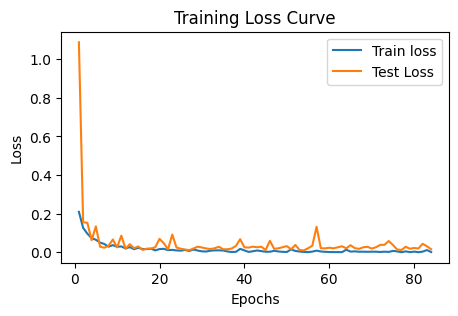

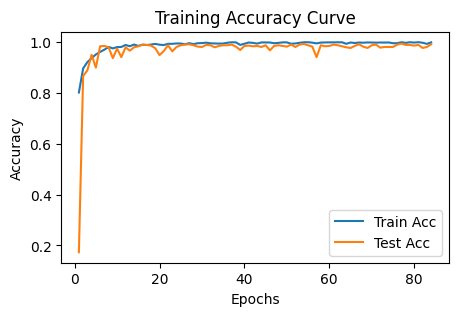

In [40]:
plot_curves(history, "Treinamento")

>   >    >    Para 5 classes

In [24]:
## teste

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_results(y_test, preds):
  miner_list_preds = []
  cerscospora_list_preds = []
  Healthy_preds = []
  leaf_rust_preds = []
  phoma_list_preds = []
  miner_list= []
  cerscospora_list = []
  Healthy_list = []
  leaf_rust_list = []
  phoma_list = []
  for i in range(len(preds)):
    Healthy_preds.append(preds[i][0])
    leaf_rust_preds.append(preds[i][1])
    miner_list_preds.append(preds[i][2])
    cerscospora_list_preds.append(preds[i][3])
    phoma_list_preds.append(preds[i][4])

    Healthy_list.append(y_test[i][0])
    leaf_rust_list.append(y_test[i][1])
    miner_list.append(y_test[i][2])
    cerscospora_list.append(y_test[i][3])
    phoma_list.append(y_test[i][4])

  acc_aline = accuracy_score(Healthy_list, Healthy_preds)
  print('The accuracy for Healthy: ', acc_aline)
  acc_bline = accuracy_score(leaf_rust_list, leaf_rust_preds)
  print('The accuracy for leaf_rust: ', acc_bline)
  acc_effusion = accuracy_score(miner_list, miner_list_preds)
  print('The accuracy for miner: ', acc_effusion)
  acc_consolid = accuracy_score(cerscospora_list, cerscospora_list_preds)
  print('The accuracy for cerscospora: ', acc_consolid)
  acc_pli = accuracy_score(phoma_list, phoma_list_preds)
  print('The accuracy for phoma: ', acc_pli)

  # Plot confusion matrix for HEALTHY LEAFS
  matriz_aline = confusion_matrix(Healthy_list, Healthy_preds)
  ax1 = plt.axes()
  sns.heatmap(matriz_aline, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax1.set_title('Healthy')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()

  #
  # Plot confusion matrix for LEAF RUST
  matriz_bline = confusion_matrix(leaf_rust_list, leaf_rust_preds)
  ax2 = plt.axes()
  sns.heatmap(matriz_bline, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax2.set_title('leaf_rust')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()

  # Plot confusion matrix for MINER
  matriz_effusion = confusion_matrix(miner_list, miner_list_preds)
  ax3 = plt.axes()
  sns.heatmap(matriz_effusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax3.set_title('Miner')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()

  # Plot confusion matrix for CERSCOSPORA
  matriz_consolidations = confusion_matrix(cerscospora_list, cerscospora_list_preds)
  ax4 = plt.axes()
  sns.heatmap(matriz_consolidations, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax4.set_title('cerscospora')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()

  # Plot confusion matrix for PHOMA
  matriz_pli = confusion_matrix(phoma_list, phoma_list_preds)
  ax5 = plt.axes()
  sns.heatmap(matriz_pli, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax5.set_title('phoma')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()




# teste meio grandeplot_curves(history, 'teste')

>   >    >    Para 4 Classes

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_results(y_test, preds):
  miner_list_preds = []
  cerscospora_list_preds = []
  # Healthy_preds = []
  leaf_rust_preds = []
  phoma_list_preds = []
  miner_list= []
  cerscospora_list = []
  # Healthy_list = []
  leaf_rust_list = []
  phoma_list = []
  for i in range(len(preds)):
    # Healthy_preds.append(preds[i][0])
    leaf_rust_preds.append(preds[i][0])
    miner_list_preds.append(preds[i][1])
    cerscospora_list_preds.append(preds[i][2])
    phoma_list_preds.append(preds[i][3])
    # Healthy_list.append(y_test[i][0])
    leaf_rust_list.append(y_test[i][0])
    miner_list.append(y_test[i][1])
    cerscospora_list.append(y_test[i][2])
    phoma_list.append(y_test[i][3])
  # acc_aline = accuracy_score(Healthy_list, Healthy_preds)
  # print('The accuracy for Healthy: ', acc_aline)
  acc_bline = accuracy_score(leaf_rust_list, leaf_rust_preds)
  print('The accuracy for leaf_rust: ', acc_bline)
  acc_effusion = accuracy_score(miner_list, miner_list_preds)
  print('The accuracy for miner: ', acc_effusion)
  acc_consolid = accuracy_score(cerscospora_list, cerscospora_list_preds)
  print('The accuracy for cerscospora: ', acc_consolid)
  acc_pli = accuracy_score(phoma_list, phoma_list_preds)
  print('The accuracy for phoma: ', acc_pli)

  # # Plot confusion matrix for HEALTHY LEAFS
  # matriz_aline = confusion_matrix(Healthy_list, Healthy_preds)
  # ax1 = plt.axes()
  # sns.heatmap(matriz_aline, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  # ax1.set_title('Healthy')
  # plt.xlabel('Prediction')
  # plt.ylabel('Ground truth')
  # plt.show()

  #
  # Plot confusion matrix for LEAF RUST
  matriz_bline = confusion_matrix(leaf_rust_list, leaf_rust_preds)
  ax2 = plt.axes()
  sns.heatmap(matriz_bline, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax2.set_title('leaf_rust')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()

  # Plot confusion matrix for MINER
  matriz_effusion = confusion_matrix(miner_list, miner_list_preds)
  ax3 = plt.axes()
  sns.heatmap(matriz_effusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax3.set_title('Miner')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()

  # Plot confusion matrix for CERSCOSPORA
  matriz_consolidations = confusion_matrix(cerscospora_list, cerscospora_list_preds)
  ax4 = plt.axes()
  sns.heatmap(matriz_consolidations, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax4.set_title('cerscospora')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()

  # Plot confusion matrix for PHOMA
  matriz_pli = confusion_matrix(phoma_list, phoma_list_preds)
  ax5 = plt.axes()
  sns.heatmap(matriz_pli, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax5.set_title('phoma')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()




# plot_curves(history, 'teste')

**matriz confusão 5x5**

24/24 [==============================] - 22s 354ms/step
--------------- ACCURACY ----------------
The accuracy for Healthy: 1.0000
The accuracy for Rust: 1.0000
The accuracy for Miner: 0.9933
The accuracy for Cercospora: 0.9947
The accuracy for Phoma: 0.9947
accuracy:   0.9880
Confusion matrix, without normalization
--------------- PRECISION ----------------
The precision for Healthy: 1.0000
The precision for Rust: 1.0000
The precision for Miner: 0.9877
The precision for Cercospora: 0.9692
The precision for Phoma: 0.9790
The mean precision across all classes: 0.9872


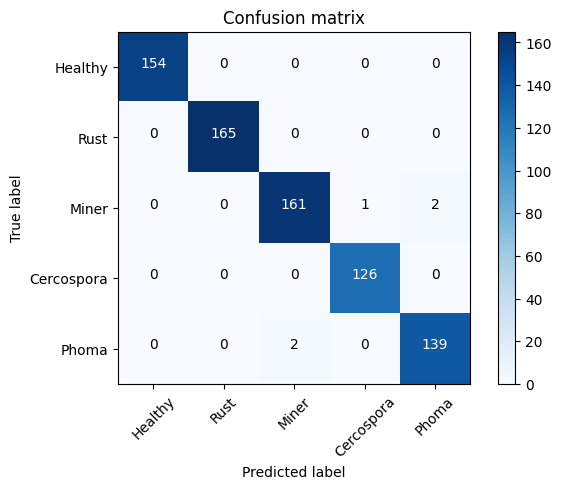

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

preds = model_all_0.predict(X_val)
preds = np.array(preds> 0.2) #limiar
preds



import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


from sklearn import metrics
import itertools

# Calculando a acurácia para cada classe
print('--------------- ACCURACY ----------------')
class_accuracy = {}
for i, class_name in enumerate(['Healthy', 'Rust', 'Miner', 'Cercospora', 'Phoma']):
    class_labels = y_val[:, i]
    class_preds = preds[:, i]
    class_accuracy[class_name] = accuracy_score(class_labels, class_preds)
    print(f"The accuracy for {class_name}: {class_accuracy[class_name]:.4f}")


score = metrics.accuracy_score(y_val, preds)
print("accuracy:   %0.4f" % score)

cm = metrics.confusion_matrix(y_val.argmax(axis=1), preds.argmax(axis=1))
plot_confusion_matrix(cm, classes=['Healthy', 'Rust', 'Miner', 'Cercospora', 'Phoma'])



from sklearn.metrics import precision_score

# Calculando a precisão para cada classe
print('--------------- PRECISION ----------------')
class_precision = {}
for i, class_name in enumerate(['Healthy', 'Rust', 'Miner', 'Cercospora', 'Phoma']):
    class_labels = y_val[:, i]
    class_preds = preds[:, i]
    class_precision[class_name] = precision_score(class_labels, class_preds)
    print(f"The precision for {class_name}: {class_precision[class_name]:.4f}")

# Calculando a precisão média
mean_precision = sum(class_precision.values()) / len(class_precision)
print(f"The mean precision across all classes: {mean_precision:.4f}")


24/24 [==============================] - 2s 99ms/step
The accuracy for Healthy:  1.0
The accuracy for leaf_rust:  1.0
The accuracy for miner:  0.9906666666666667
The accuracy for cerscospora:  0.9946666666666667
The accuracy for phoma:  0.9933333333333333


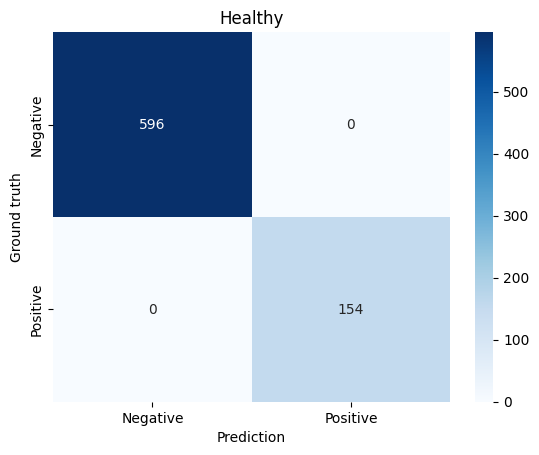

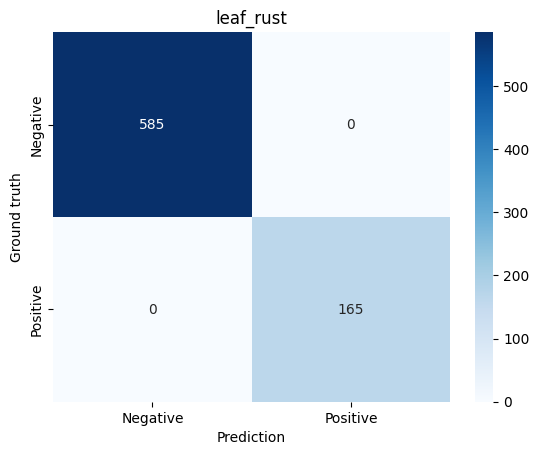

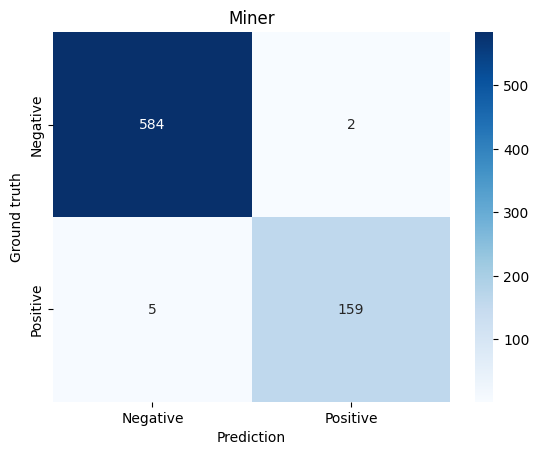

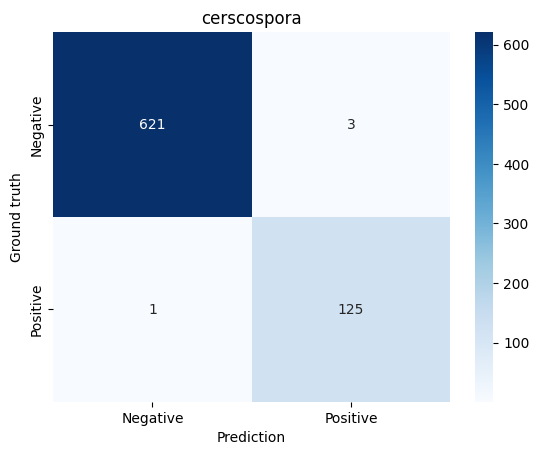

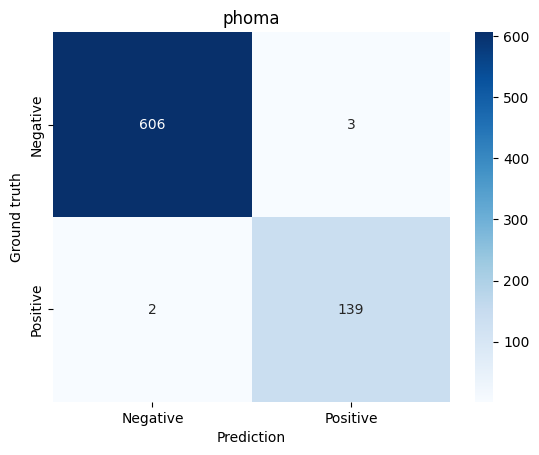

In [42]:
# Teste com o conjunto Z

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
preds = model_all_0.predict(X_val)
preds = np.array(preds> 0.5) #limiar
preds



plot_results(y_val, preds)



In [ ]:
# Teste Unitario
img = tf.keras.utils.load_img("/content/Data/Phoma/242_1151_0568_0150_0162.jpg", target_size=(224, 224), color_mode="grayscale")
img = tf.keras.utils.img_to_array(img)
img = img/255.

preds = model_all_0.predict(tf.expand_dims(tf.convert_to_tensor(img), axis = 0))
preds = np.array(preds> 0.5) #limiar
#preds
#for i in folders:
#  print(i[-10:])
preds

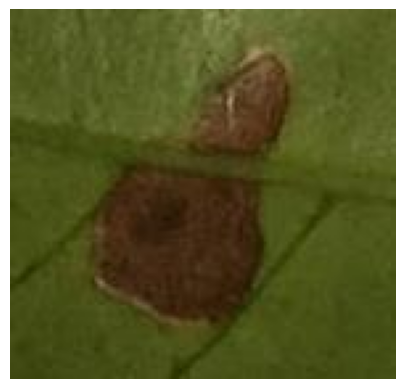

1/1 [==============================] - 4s 4s/step
[[5.7536237e-12 8.4307855e-10 1.0000000e+00 6.0510430e-10 3.9610226e-09]]
[[False False  True False False]]
['Healthy', 'Leaf Rust', 'Miner', 'Cercospora', 'Phoma']
Miner


In [ ]:
import matplotlib.pyplot as plt
import cv2

img = "/content/symptom/miner/1003_0519_0488_0146_0140.jpg"

image = cv2.imread(img)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')  # Desativar os eixos
plt.show()


# Teste Unitario RGB
img = tf.keras.utils.load_img(img , target_size=(224, 224), color_mode="rgb")
img = tf.keras.utils.img_to_array(img)
img = img/255.

preds = model_all_0.predict(tf.expand_dims(tf.convert_to_tensor(img), axis=0))
print(np.array(preds))
preds = np.array(preds > 0.5)  # limiar
print(preds)
print("['Healthy', 'Leaf Rust', 'Miner', 'Cercospora', 'Phoma']")


# Lista de classes
classes = ['Healthy', 'Leaf Rust', 'Miner', 'Cercospora', 'Phoma']
predicted_class_index = np.where(preds[0])[0][0]
predicted_class = classes[predicted_class_index]

print(predicted_class)

# **Salvar Resultados**

In [29]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [43]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/TCC/Notebooks/multilabel_folhasDeCafé (RGB).ipynb' --output '/content/drive/MyDrive/TCC/Resultados RGB/'ShuffletNet' 'DatasetJMUBEN'/Notebook.pdf'

[NbConvertApp] Converting notebook /content/drive/MyDrive/TCC/Notebooks/multilabel_folhasDeCafé (RGB).ipynb to pdf
[NbConvertApp] Support files will be in /content/drive/MyDrive/TCC/Resultados RGB/ShuffletNet DatasetJMUBEN/Notebook_files/
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/ShuffletNet DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/ShuffletNet DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/ShuffletNet DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/ShuffletNet DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/ShuffletNet DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/ShuffletNet DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/ShuffletNet DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/R

In [ ]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/TCC/Notebooks/multilabel_folhasDeCafé (RGB).ipynb' --output '/content/drive/MyDrive/TCC/Resultados RGB/'InceptionResnetv1' 'DatasetJMUBEN'/Notebook.pdf'

[NbConvertApp] Converting notebook /content/drive/MyDrive/TCC/Notebooks/multilabel_folhasDeCafé (RGB).ipynb to pdf
[NbConvertApp] Support files will be in /content/drive/MyDrive/TCC/Resultados RGB/InceptionResnetv1 DatasetJMUBEN/Notebook_files/
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/InceptionResnetv1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/InceptionResnetv1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/InceptionResnetv1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/InceptionResnetv1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/InceptionResnetv1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/InceptionResnetv1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/InceptionResnetv1 DatasetJMUBEN
[NbConvertAp

In [ ]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/TCC/Notebooks/multilabel_folhasDeCafé (RGB).ipynb' --output '/content/drive/MyDrive/TCC/Resultados RGB/'Resnet50V1' 'DatasetJMUBEN'/Notebook.pdf'

In [ ]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/TCC/Notebooks/multilabel_folhasDeCafé (RGB).ipynb' --output '/content/drive/MyDrive/TCC/Resultados RGB/'PavicNetV7' 'DatasetBRACOL'/Notebook.pdf'

[NbConvertApp] Converting notebook /content/drive/MyDrive/TCC/Notebooks/multilabel_folhasDeCafé (RGB).ipynb to pdf
[NbConvertApp] Support files will be in /content/drive/MyDrive/TCC/Resultados RGB/PavicNetV7 DatasetBRACOL/Notebook_files/
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/PavicNetV7 DatasetBRACOL
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/PavicNetV7 DatasetBRACOL
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/PavicNetV7 DatasetBRACOL
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/PavicNetV7 DatasetBRACOL
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/PavicNetV7 DatasetBRACOL
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/PavicNetV7 DatasetBRACOL
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/PavicNetV7 DatasetBRACOL
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultado

In [ ]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/TCC/Notebooks/multilabel_folhasDeCafé (RGB).ipynb' --output '/content/drive/MyDrive/TCC/Resultados RGB/'DensenetV1' 'DatasetJMUBEN'/Notebook.pdf'

[NbConvertApp] Converting notebook /content/drive/MyDrive/TCC/Notebooks/multilabel_folhasDeCafé (RGB).ipynb to pdf
[NbConvertApp] Support files will be in /content/drive/MyDrive/TCC/Resultados RGB/DensenetV1 DatasetJMUBEN/Notebook_files/
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/DensenetV1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/DensenetV1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/DensenetV1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/DensenetV1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/DensenetV1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/DensenetV1 DatasetJMUBEN
[NbConvertApp] Making directory /content/drive/MyDrive/TCC/Resultados RGB/DensenetV1 DatasetJMUBEN
[NbConvertApp] Writing 232979 bytes to notebook.tex
[NbConvertApp] B